# Preamble

In [11]:
from load_functions import *
from model_functions import *
import emcee
import sys
from scipy.interpolate import interp1d

plt.rcdefaults()
fontsize = 14
rcParams['font.family'] = 'sans-serif'
font_manager.findfont('serif', rebuild_if_missing=True)
rcParams.update({'font.size':fontsize})

In [12]:
HomeDir = '/Users/shalm/Dropbox/LuminousBasin/luminous-basin/'
DataDir = HomeDir+'data/likelihood_yellin_data/products_80610202001_orbit1_chu12_spatialARF/'
ResultsDir = HomeDir+'data/results/'
sys.path.insert(0, HomeDir)

# FOR THE CLUSTER
#from Likelihood_Functions import *
#HomeDir = '/home/srw9487/LuminousBasin/'
#DataDir = HomeDir+'products_80610202001_orbit1_chu12_spatialARF/'
#MockDataDir = HomeDir+'mock data/Event Lists/'

#FOR TESTING
#from Likelihood_Functions import *
#HomeDir = '/Users/shalm/Dropbox/LuminousBasin/code/'
#DataDir = HomeDir+'master/likelihood/products_80610202001_orbit1_chu12_spatialARF/'
#MockDataDir = HomeDir+'Shalma code/mock data/Event Lists/'
#MockResultsDir = '/Users/shalm/Dropbox/LuminousBasin/luminous-basin/mocks/results/'
#sys.path.insert(0, HomeDir)

# Parameters

In [13]:
m = 120 # axion mass
sigma_E = 0.166 # energy resolution

In [14]:
good_time_ints = [
(  3.37603080e+08,   3.37603330e+08),
(  3.37603330e+08,   3.37603380e+08),
(  3.37603380e+08,   3.37603380e+08),
(  3.37603580e+08,   3.37603581e+08),
(  3.37603630e+08,   3.37605080e+08),
(  3.37605081e+08,   3.37605230e+08)]
exposure = np.sum([interval[1]-interval[0] for interval in good_time_ints])
livetime = np.asarray([1501.16599845754, 1481.86081041239])/exposure # effective fractional livetime of A and B
duration = np.max(good_time_ints)- np.min(good_time_ints)

In [15]:
# time bins
N_bins_t = 10
bins_t = np.linspace(good_time_ints[1][0], good_time_ints[-1][1], N_bins_t+1)
# energy bins
width_E = 0.04 # energy bin width is 40 keV
bins_E = np.arange(1.6,200.01,width_E)
#n_sigma_E = 3

# HIGH ENERGY EVENTS:
#n_sigma_E = 250

# ALL EVENTS:
n_sigma_E = 370

In [16]:
print(sigma_E*n_sigma_E)

61.42


In [17]:
list_file_events = [DataDir+'event_lists/'+file for file in listdir(DataDir+'event_lists/') if file[0:2]=='nu'] #select only files starting with 'nu'
file_box_centers = DataDir+'box_centers.txt'
list_file_arf = [DataDir+'arfs/'+file for file in listdir(DataDir+'arfs/')]

In [18]:
# fiducial solar position 
ra_sun_fid = 170.66855149 * degree
dec_sun_fid = 4.02092024 * degree
# error on solar position 
sigma_sun = 2 * arcmin
# shift in solar position over duration starting from t_min
delta_ra_sun = 0.01962028 * degree
delta_dec_sun = -0.00835105 * degree
t_min = 3.37603341e+08
sigma_sun = 2*arcmin # error on solar position

# initial solar position
ra_sun_0 = ra_sun_fid
dec_sun_0 = dec_sun_fid

# Load Data

In [19]:
df_data = load_data(m,sigma_E,good_time_ints,livetime,bins_t,bins_E,n_sigma_E,list_file_events,file_box_centers,list_file_arf)

C:\Users\shalm\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [20]:
df_data

,detector,idx_t,idx_E,i1,i2,t,E,ra,dec,exp,arf,Omega,counts
0,A,0,0,-6,-6,337603330.0,1.6,170.889,3.75981,39.504368,0.649652,1.0,0
1,A,0,0,-6,-5,337603330.0,1.6,170.881,3.77425,39.504368,0.472580,1.0,0
2,A,0,0,-6,-4,337603330.0,1.6,170.872,3.78868,39.504368,0.779855,1.0,1
3,A,0,0,-6,-3,337603330.0,1.6,170.864,3.80311,39.504368,0.763282,1.0,0
4,A,0,0,-6,-2,337603330.0,1.6,170.856,3.81755,39.504368,1.329886,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10126475,B,9,2995,6,2,337605040.0,121.4,171.009,3.97187,147.406154,0.000000,1.0,0
10126476,B,9,2995,6,3,337605040.0,121.4,171.001,3.98630,147.406154,0.000000,1.0,0
10126477,B,9,2995,6,4,337605040.0,121.4,170.992,4.00073,147.406154,0.000000,1.0,0
10126478,B,9,2995,6,5,337605040.0,121.4,170.984,4.01517,147.406154,0.000000,1.0,0


In [21]:
np.sum(df_data['counts'])

26089

In [22]:
t = df_data['t'].to_numpy()
E = df_data['E'].to_numpy()
ra = df_data['ra'].to_numpy()
dec = df_data['dec'].to_numpy()
eps = df_data['exp'].to_numpy() * df_data['arf'].to_numpy() * (df_data['Omega'].to_numpy() * arcmin**2 / (degree**2)) * width_E
counts = df_data['counts'].to_numpy()

In [221]:
df_group = df_data[['E','counts']]
df_group = df_group[df_group['E']>6]
df_group

,E,counts
18590,6.0,0
18591,6.0,0
18592,6.0,0
18593,6.0,0
18594,6.0,0
...,...,...
10126475,121.4,0
10126476,121.4,0
10126477,121.4,0
10126478,121.4,0


In [222]:
df_grouped_data = df_group.groupby(by=['E'],as_index=False).sum()
df_grouped_data

,E,counts
0,6.00,1
1,6.04,1
2,6.08,4
3,6.12,4
4,6.16,3
...,...,...
2881,121.24,1
2882,121.28,0
2883,121.32,0
2884,121.36,0


In [223]:
grouped_E = df_grouped_data['E'].to_numpy()
grouped_counts = df_grouped_data['counts'].to_numpy()

In [142]:
df_results_yellin = pd.read_csv(ResultsDir+'results_k10_fid.csv')
df_results_yellin

,m,ra_sun_0,dec_sun_0,rho_0,N_data,N_sig_lim_poisson,S_0_lim_poisson,N_sig_lim_yellin,S_0_lim_yellin
0,3.2,2.978728,0.070178,296.513448,12721,12864.742387,43.386708,6325.111361,21.331617
1,3.3,2.978728,0.070178,398.950885,13348,13495.882921,33.828432,6319.313656,15.839829
2,3.4,2.978728,0.070178,514.408935,13930,14079.962107,27.371146,6463.155766,12.564237
3,3.5,2.978728,0.070178,645.655228,14995,15151.017660,23.466112,5806.716361,8.993525
4,3.6,2.978728,0.070178,785.449821,15448,15607.089944,19.870257,5558.469388,7.076798
...,...,...,...,...,...,...,...,...,...
363,39.5,2.978728,0.070178,25392.314178,9,14.204028,0.000559,2.303297,0.000091
364,39.6,2.978728,0.070178,25307.006674,9,14.204028,0.000561,2.303297,0.000091
365,39.7,2.978728,0.070178,25218.871552,9,14.204028,0.000563,2.303297,0.000091
366,39.8,2.978728,0.070178,25089.057583,9,14.204028,0.000566,2.303297,0.000092


In [14]:
idx = np.where(np.abs(df_results_yellin['m']-m)<0.05)[0][0]
S0_guess = df_results_yellin['S_0_lim_poisson'][idx]
df_results_yellin.iloc[idx]

IndexError: index 0 is out of bounds for axis 0 with size 0

## New Background Model

In [23]:
df_background = pd.read_csv('brian_backgrounds.txt',delimiter=" ", skiprows=3,header=None)
df_background.columns = ["Energy [keV]","unknown","Total", "aCXB", "Internal", "fXCB","Continuum"]
df_background

,Energy [keV],unknown,Total,aCXB,Internal,fXCB,Continuum
0,1.620000,0.020000,0.000185,3.594298e-05,1.808465e-06,0.000003,0.000144
1,1.660000,0.020000,0.000194,4.424206e-05,2.023978e-06,0.000003,0.000144
2,1.700000,0.020000,0.000204,5.304552e-05,2.230286e-06,0.000004,0.000145
3,1.740000,0.020000,0.000214,6.219269e-05,2.424499e-06,0.000004,0.000145
4,1.780000,0.020000,0.000225,7.193359e-05,2.609324e-06,0.000005,0.000145
...,...,...,...,...,...,...,...
4091,165.260010,0.019997,0.000229,2.040408e-08,9.147808e-08,0.000000,0.000229
4092,165.300003,0.020004,0.000229,1.926954e-08,8.636118e-08,0.000000,0.000229
4093,165.339996,0.019997,0.000229,1.805362e-08,8.088239e-08,0.000000,0.000229
4094,165.380005,0.019997,0.000229,1.691932e-08,7.578295e-08,0.000000,0.000229


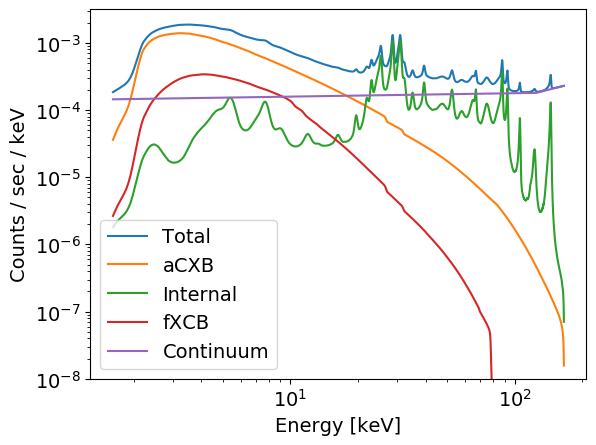

In [24]:
plt.plot(df_background['Energy [keV]'].to_numpy(dtype=float),df_background['Total'].to_numpy(dtype=float),label='Total')
plt.plot(df_background['Energy [keV]'].to_numpy(dtype=float),df_background['aCXB'].to_numpy(dtype=float),label='aCXB')
plt.plot(df_background['Energy [keV]'].to_numpy(dtype=float),df_background['Internal'].to_numpy(dtype=float),label='Internal')
plt.plot(df_background['Energy [keV]'].to_numpy(dtype=float),df_background['fXCB'].to_numpy(dtype=float),label='fXCB')
plt.plot(df_background['Energy [keV]'].to_numpy(dtype=float),df_background['Continuum'].to_numpy(dtype=float),label='Continuum')
#plt.plot(df_background['Energy [keV]'].to_numpy(dtype=float),df_background['unknown'].to_numpy(dtype=float),label='unknown')

plt.xscale('log')
plt.yscale('log')
plt.ylim(10**(-8),10**(-2.5))
plt.xlabel('Energy [keV]')
plt.ylabel('Counts / sec / keV')
plt.legend()
plt.savefig('background_plot.png')

In [71]:
E_bg = df_background['Energy [keV]'].to_numpy(dtype=float)
Total_bg = df_background['Total'].to_numpy(dtype=float)
aCXB_bg = df_background['aCXB'].to_numpy(dtype=float)
Internal_bg = df_background['Internal'].to_numpy(dtype=float)
fXCB_bg = df_background['fXCB'].to_numpy(dtype=float)
Continuum_bg = df_background['Continuum'].to_numpy(dtype=float)

In [212]:
f_total_bg = interp1d(E_bg,Total_bg,fill_value='extrapolate')
f_aCXB_bg = interp1d(E_bg, aCXB_bg,fill_value='extrapolate')
f_internal_bg = interp1d(E_bg, Internal_bg,fill_value='extrapolate')
f_continuum_bg = interp1d(E_bg, Continuum_bg,fill_value='extrapolate')

In [74]:
f_aCXB_bg(3)

array(0.00136656)

# Checks

In [18]:
np.sum(counts), df_results_yellin.iloc[idx]['N_data']

NameError: name 'idx' is not defined

In [19]:
S0_guess * np.mean(T_flux_template(t,ra,dec,ra_sun_0,dec_sun_0,delta_ra_sun,delta_dec_sun,t_min,duration)) * np.mean(df_data['arf']) * (2*13**2*arcmin**2 / degree**2) * exposure * 4 * sigma_E

NameError: name 'S0_guess' is not defined

In [20]:
print(pd.__version__)

0.25.1


# Fit for continuum background at 50 keV

In [27]:
from scipy.optimize import curve_fit

In [224]:
bin_width = width_E*10

In [159]:
new_E = []
new_counts = []
for i in range(len(grouped_E)):
    if grouped_E[i] <= 100:
        new_E.append(grouped_E[i])
        new_counts.append(grouped_counts[i])

In [225]:
bins = np.arange(6,100,bin_width)

In [226]:
new_counts, new_E = np.histogram(data_hist,bins = bins)

In [227]:
new_E += bin_width/2

In [228]:
new_E = new_E[:-1]

In [229]:
new_E

array([ 6.2,  6.6,  7. ,  7.4,  7.8,  8.2,  8.6,  9. ,  9.4,  9.8, 10.2,
       10.6, 11. , 11.4, 11.8, 12.2, 12.6, 13. , 13.4, 13.8, 14.2, 14.6,
       15. , 15.4, 15.8, 16.2, 16.6, 17. , 17.4, 17.8, 18.2, 18.6, 19. ,
       19.4, 19.8, 20.2, 20.6, 21. , 21.4, 21.8, 22.2, 22.6, 23. , 23.4,
       23.8, 24.2, 24.6, 25. , 25.4, 25.8, 26.2, 26.6, 27. , 27.4, 27.8,
       28.2, 28.6, 29. , 29.4, 29.8, 30.2, 30.6, 31. , 31.4, 31.8, 32.2,
       32.6, 33. , 33.4, 33.8, 34.2, 34.6, 35. , 35.4, 35.8, 36.2, 36.6,
       37. , 37.4, 37.8, 38.2, 38.6, 39. , 39.4, 39.8, 40.2, 40.6, 41. ,
       41.4, 41.8, 42.2, 42.6, 43. , 43.4, 43.8, 44.2, 44.6, 45. , 45.4,
       45.8, 46.2, 46.6, 47. , 47.4, 47.8, 48.2, 48.6, 49. , 49.4, 49.8,
       50.2, 50.6, 51. , 51.4, 51.8, 52.2, 52.6, 53. , 53.4, 53.8, 54.2,
       54.6, 55. , 55.4, 55.8, 56.2, 56.6, 57. , 57.4, 57.8, 58.2, 58.6,
       59. , 59.4, 59.8, 60.2, 60.6, 61. , 61.4, 61.8, 62.2, 62.6, 63. ,
       63.4, 63.8, 64.2, 64.6, 65. , 65.4, 65.8, 66

In [230]:
#def power_law(E, a, b):
#    return a*np.power(E, b)+f_internal_bg(E)*exposure*width_E

def fit_function(E, a, b, c):
    #counts_per_keV_sec = a*f_aCXB_bg(E)+ b*np.power(E,c) + d*f_internal_bg(E)
    counts_per_keV_sec = a*f_aCXB_bg(E)+ b*f_continuum_bg(E) + c*f_internal_bg(E)
    return counts_per_keV_sec*exposure*bin_width

In [231]:
pars, cov = curve_fit(f=fit_function, xdata=new_E, ydata=new_counts, p0=[10,1,1], bounds=(0, np.inf))
stdevs = np.sqrt(np.diag(cov))
res = new_counts - fit_function(new_E, *pars)

In [232]:
pars

array([29.64408582, 26.35289817, 20.44859448])

In [233]:
max(res)

11.905456858812498

In [31]:
exposure

1900.0

In [32]:
width_E

0.04

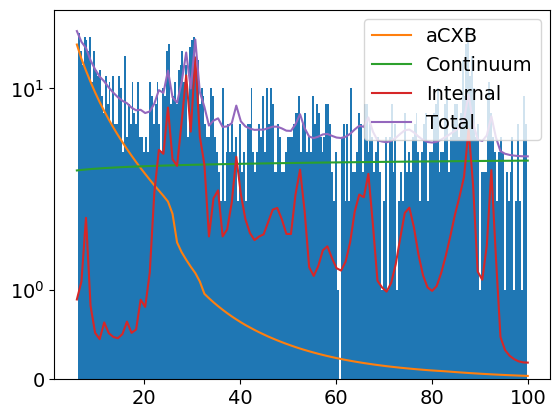

In [236]:
E_plotlist = np.linspace(6,100,100)
aCXBlist = [f_aCXB_bg(i)*pars[0]*exposure*bin_width for i in E_plotlist]
#powerlist = [pars[1]*np.power(i, pars[2])*exposure*bin_width for i in E_plotlist]
powerlist = [pars[1]*f_continuum_bg(i)*exposure*bin_width for i in E_plotlist]
internallist = [f_internal_bg(i)*pars[2]*exposure*bin_width for i in E_plotlist]
totallist = [fit_function(i,pars[0],pars[1],pars[2]) for i in E_plotlist]
plt.hist(data_hist,bins = bins)
plt.plot(E_plotlist, aCXBlist, label= 'aCXB')
plt.plot(E_plotlist, powerlist, label= 'Continuum')
plt.plot(E_plotlist, internallist, label= 'Internal')
plt.plot(E_plotlist, totallist,label = 'Total')
plt.yscale('symlog')
#plt.xscale('log')
plt.legend()

C:\Users\shalm\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


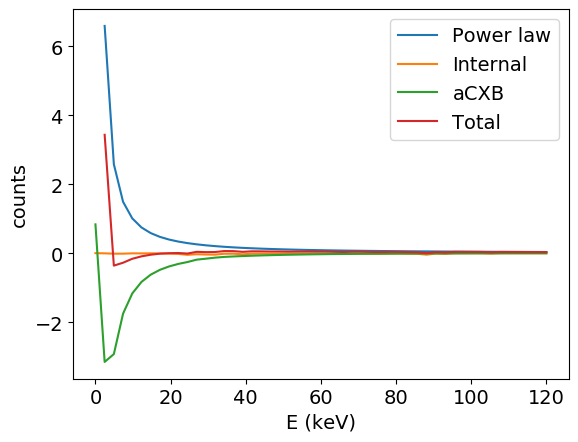

In [37]:
E_plotlist = np.linspace(0,120)
powerlist = [pars[0]*np.power(i, pars[1])*exposure for i in E_plotlist]
internallist = [f_internal_bg(i)*pars[2]*exposure for i in E_plotlist]
aCXBlist = [f_aCXB_bg(i)*pars[3]*exposure for i in E_plotlist]
total_fit = [powerlist[i]+internallist[i]+aCXBlist[i] for i in range(len(powerlist))]
plt.plot(E_plotlist, powerlist,label = 'Power law')
plt.plot(E_plotlist, internallist,label = 'Internal')
plt.plot(E_plotlist, aCXBlist, label= 'aCXB')
plt.plot(E_plotlist, total_fit,label = 'Total')
plt.ylabel('counts')
plt.xlabel('E (keV)')
plt.legend()

C:\Users\shalm\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


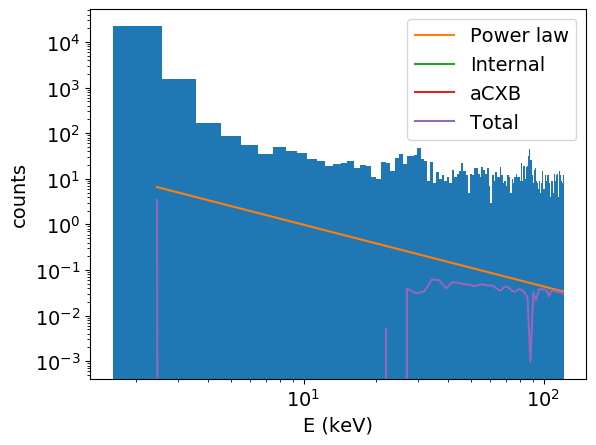

In [38]:
plt.hist(data_hist,bins=123)
E_plotlist = np.linspace(0,120)
powerlist = [pars[0]*np.power(i, pars[1])*exposure for i in E_plotlist]
internallist = [f_internal_bg(i)*pars[2]*exposure for i in E_plotlist]
aCXBlist = [f_aCXB_bg(i)*pars[3]*exposure for i in E_plotlist]
total_fit = [powerlist[i]+internallist[i]+aCXBlist[i] for i in range(len(powerlist))]
plt.plot(E_plotlist, powerlist,label = 'Power law')
plt.plot(E_plotlist, internallist,label = 'Internal')
plt.plot(E_plotlist, aCXBlist, label= 'aCXB')
plt.plot(E_plotlist, total_fit,label = 'Total')
plt.yscale('log')
plt.ylabel('counts')
plt.xscale('log')
plt.xlabel('E (keV)')
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (50,) and (150000,)

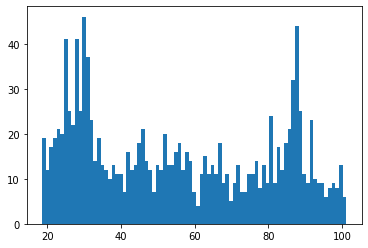

In [120]:
plt.hist(data_hist,bins=83)
#E_plotlist = np.linspace(20,100)
plt.plot(E_plotlist, powerlist,label = 'Power law')
plt.plot(E_plotlist, internallist,label = 'Internal backgrounds')
#plt.plot(E_plotlist, total_powerfit,label = 'Total')
#plt.scatter(E,counts,label='Data')
plt.ylabel('counts')
plt.xlabel('E (keV)')
plt.legend()

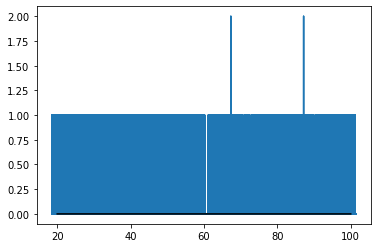

In [48]:
plt.plot(E,counts)
E_plotlist = np.linspace(20,100)
powerfit = [power_law(i,pars[0],pars[1]) for i in E_plotlist]
plt.plot(E_plotlist, powerfit,color='k')

# Global background fit

In [166]:
# Load all data:
list_tables = []
list_X = []
list_Y = []
list_E = []
list_t = []
list_t_min = []
list_t_max = []

for file in list_file_events:
    table = pd.read_csv(file)
    X = np.asarray(table[' RA (deg)'])
    Y = np.asarray(table[' Dec (deg)'])
    E = np.asarray(table[' Energy (keV)'])
    t = np.asarray(table['# Time (s)'])
    
    list_tables.append(table)
    list_X.append(X); list_Y.append(Y); list_E.append(E); list_t.append(t)
    list_t_min.append(list_t_min); list_t_max.append(list_t_max); 
    
all_X = np.asarray([item for X in list_X for item in X])
all_Y = np.asarray([item for Y in list_Y for item in Y])
all_E = np.asarray([item for E in list_E for item in E])
all_t = np.asarray([item for t in list_t for item in t])
    
[len(table) for table in list_tables]

[12805, 13693]

fig,ax = plt.subplots(1,1,figsize=(12,6))
i_tab = 1
[hist_E,E_edges,image] = ax.hist(all_E,bins=np.arange(0.02,12.0,0.04),log=True,histtype='step',alpha=0.8);
ax.hist(list_E[i_tab],bins=np.arange(0.02,12.0,0.04),log=True,histtype='step',alpha=0.8);
ax.set_xlim(0,12); ax.set_xlabel('E (keV)'); ax.set_ylabel('occurence');

In [179]:
def fit_fun(E, N):
    return N*f_aCXB_bg(E) + 0.00114068*E(-0.46469413)

E_fit_min = 5.6; E_fit_max = 9.4;
indices_fit = [E_fit_min<E<E_fit_max for E in E_edges] # fit from 4 keV to 7 keV
p0 = [5e4, 0.7, 6.4, 0.4, 0]
[p_fit,p_cov] = curve_fit(fit_fun,xdata=E_edges[indices_fit],ydata=hist_E[indices_fit[:-1]],p0=p0,sigma=np.sqrt(hist_E[indices_fit[:-1]]))

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

# MCMC

## 5 dimensions

In [113]:
def LL_prior_sun(ra_sun_0,dec_sun_0,sigma_sun=sigma_sun,ra_sun_fid=ra_sun_fid,dec_sun_fid=dec_sun_fid):
    return (np.cos(dec_sun_fid)**2 * (ra_sun_0 - ra_sun_fid)**2 + (dec_sun_0 - dec_sun_fid)**2) / (2 * sigma_sun**2)

def LL_prior_BS(B0,S0):
    LL_prior_B0 = np.piecewise(B0,[B0<=0,B0>0],[-1e5*B0,1e-10*B0])
    LL_prior_S0 = np.piecewise(S0,[S0<=0,S0>0],[-1e-5*S0,1e-5*S0])
    return LL_prior_B0 + LL_prior_S0

def LL_prior(B0,S0,ra_sun_0,dec_sun_0):
    return LL_prior_sun(ra_sun_0,dec_sun_0) + LL_prior_BS(B0,S0)

#### No Spatial Gradient Function:

In [144]:
def likelihood_MCMC_5(model_inputs,m,t,E,ra,dec,eps,counts):
    B0 = model_inputs[0]
    S0 = model_inputs[1]
    #alpha0=170.66855149
    #delta0=4.02092024
    ra_sun_0 = model_inputs[2]
    dec_sun_0 = model_inputs[3]
    flux_bkgd = B0*f_aCXB_bg(E)
    flux_signal = S0 * T_flux_template(t,ra,dec,ra_sun_0,dec_sun_0,delta_ra_sun,delta_dec_sun,t_min,duration) * np.exp(-(E-m/2)**2/(2*sigma_E**2)) / np.sqrt(2 * np.pi * sigma_E**2)
    
    if np.isnan(flux_bkgd).any() == True:
        print('nan in flux_bkgd')
    if np.isnan(flux_signal).any() == True:
        print('nan in flux_signal')
    
    #print('min flux_bg = ', min(flux_bkgd))
    #print('min flux_sig = ', min(flux_signal))
        
    mu = flux_bkgd + (flux_signal * eps)
    
    LLp = 
    
    
    if min(mu) < 0: 
        #print('skip')
        return -np.inf
    else:
        try:
            #LL = counts*np.log(mu)-mu-np.log(factorial_vec(counts)) 
            LL = counts*np.log(mu)-mu # not including factorial, as it does not depend on model params
            loss = 2 * (np.sum(LL) - LLp)
            return loss
        except ValueError:
            print('value error')
            print('min mu = ', min(mu))
            print('LLp = ',LLp)
            return -np.inf

In [145]:
nwalkers = 32
ndim = 4 # B0,S0,alpha0,delta0
p0_B0 = np.abs(np.random.normal(10*S0_guess,10*S0_guess,nwalkers))
p0_S0 = np.random.normal(0.3*S0_guess,0.3*S0_guess,nwalkers)
p0_ra_sun_0 = np.random.normal(ra_sun_fid,sigma_sun,nwalkers)
p0_dec_sun_0 = np.random.normal(dec_sun_fid,sigma_sun,nwalkers)
p0 = np.transpose([p0_B0,p0_S0,p0_ra_sun_0,p0_dec_sun_0])

In [146]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, likelihood_MCMC_5, args=[m,t,E,ra,dec,eps,counts])

In [147]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [148]:
n_steps = 1000;
sampler.run_mcmc(state, n_steps, progress=True);

100%|██████████| 1000/1000 [14:40<00:00,  1.14it/s]


In [149]:
samples = sampler.get_chain(flat=True)

In [150]:
np.shape(samples)

(32000, 4)

In [152]:
units = np.asarray([1e3,1e4,180/np.pi,180/np.pi])

In [153]:
samples_units = np.transpose(np.diag(units) @ np.transpose(samples))

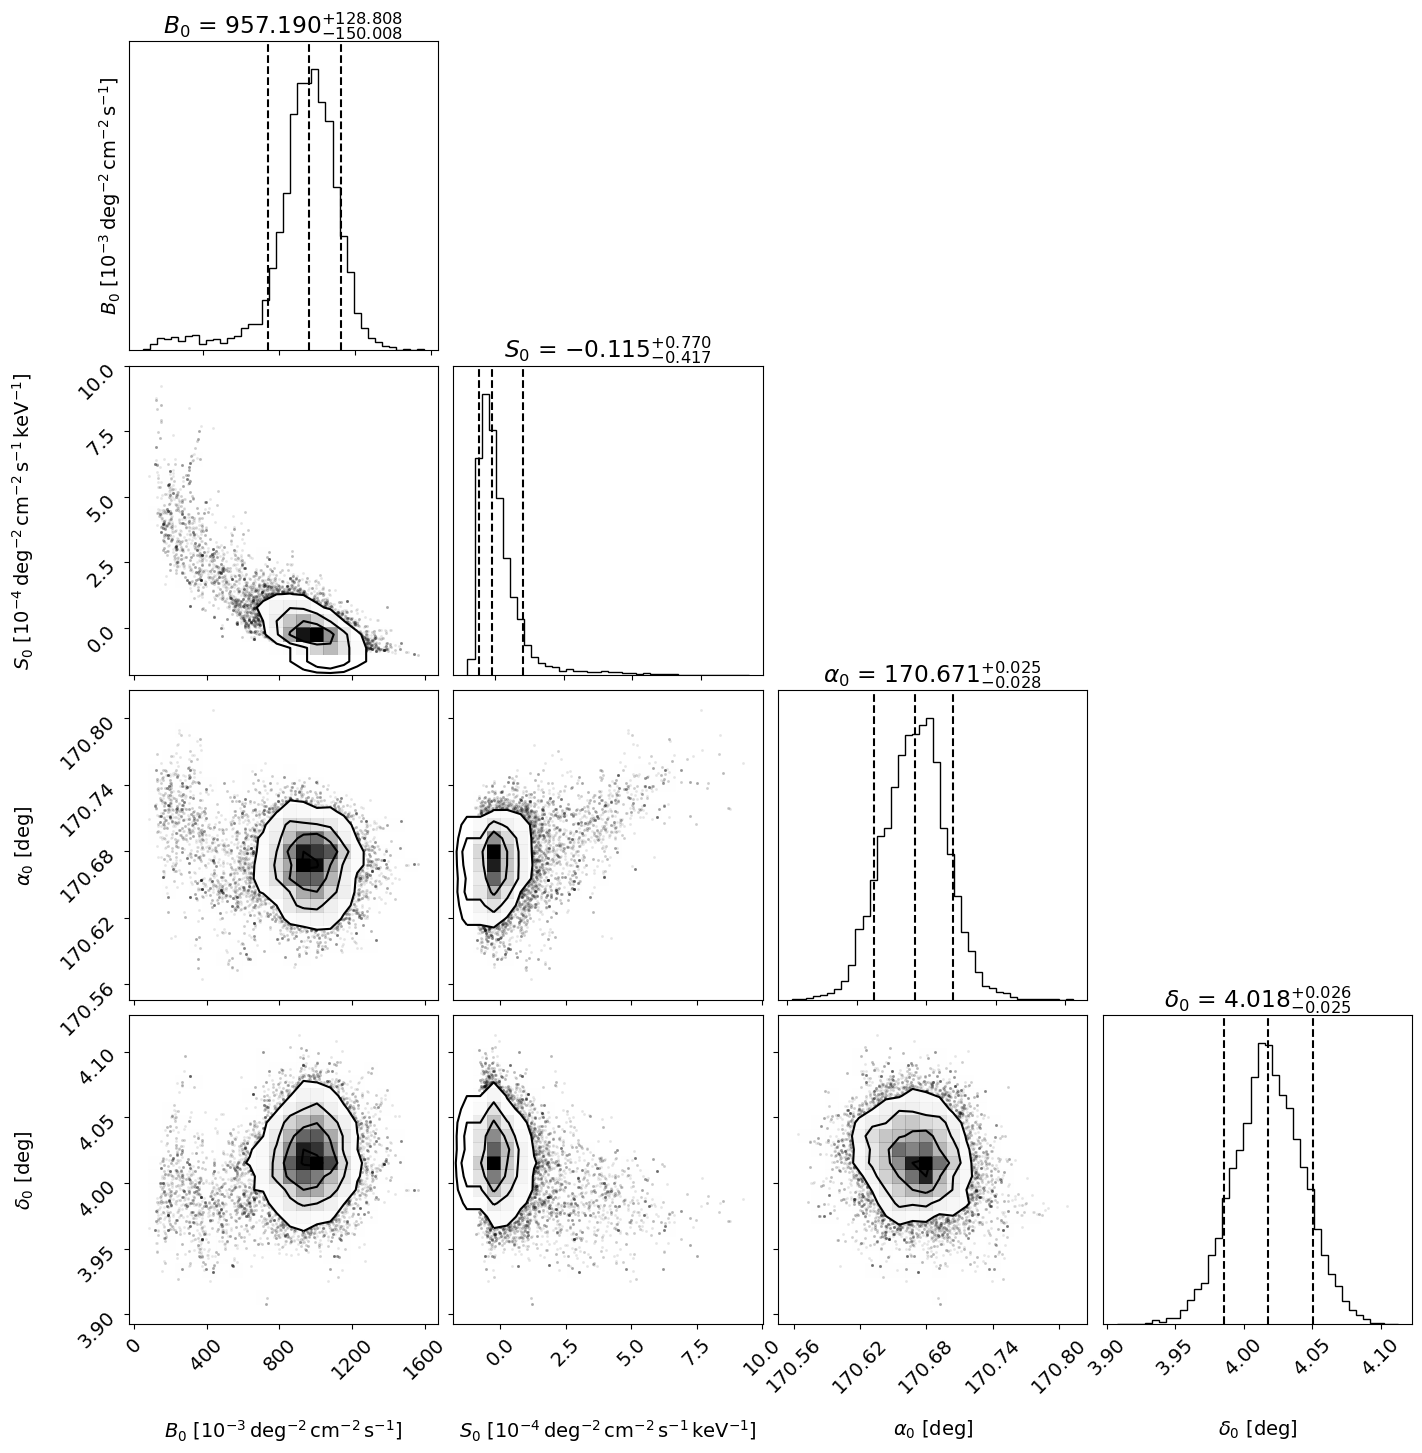

In [162]:
labels = [r'$B_0$',r'$S_0$',r'$\alpha_0$',r'$\delta_0$']
x_labels = [r'$B_0~[10^{-3}\,\mathrm{deg^{-2}\,cm^{-2}\,s^{-1}}]$',r'$S_0~[10^{-4}\,\mathrm{deg^{-2}\,cm^{-2}\,s^{-1}\,keV^{-1}}]$',r'$\alpha_0~[\mathrm{deg}]$',r'$\delta_0~[\mathrm{deg}]$']
fig,ax=plt.subplots(4,4,figsize=(15,15))
corner.corner(samples_units,fig=fig,labels=labels,show_titles=True,title_fmt='.3f',scale_hist=False,hist_bin_factor=2,top_ticks=False,quantiles=[0.1,0.5,0.9],verbose=False)
for i,x_label in enumerate(x_labels):
    ax[i,0].set_ylabel(x_label)
    ax[3,i].set_xlabel(x_label)
for i in range(2,4):
    ax[i,2].axvline(units[2] * df_results_yellin['S_0_lim_yellin'][idx],color=(0.6,0.2,0.5),ls='dashed')
for i in range(2):
    ax[2,i].axhline(units[2] * df_results_yellin['S_0_lim_yellin'][idx],color=(0.6,0.2,0.5),ls='dashed')
fig.savefig('m=18keV_corner_plot.png')

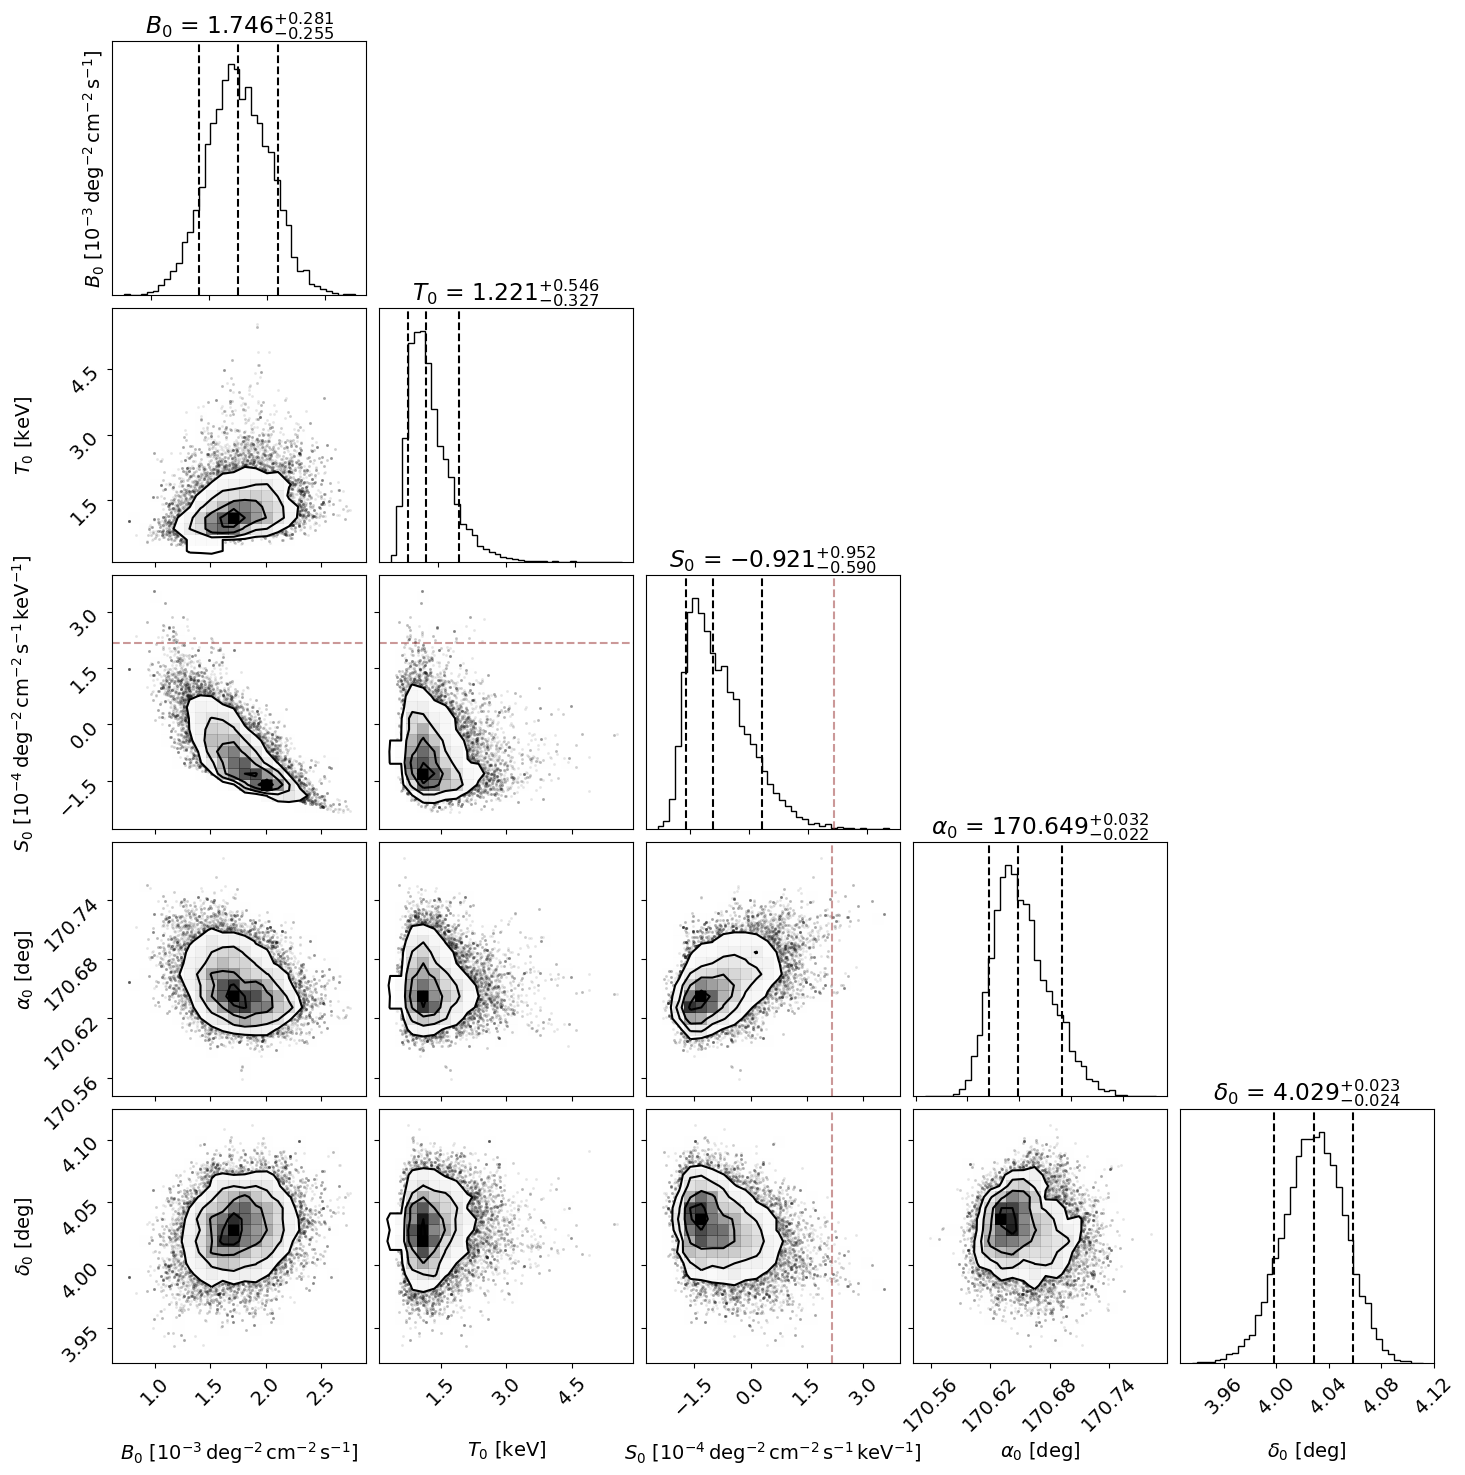

In [65]:
labels = [r'$B_0$',r'$T_0$',r'$S_0$',r'$\alpha_0$',r'$\delta_0$']
x_labels = [r'$B_0~[10^{-3}\,\mathrm{deg^{-2}\,cm^{-2}\,s^{-1}}]$',r'$T_0~[\mathrm{keV}]$',r'$S_0~[10^{-4}\,\mathrm{deg^{-2}\,cm^{-2}\,s^{-1}\,keV^{-1}}]$',r'$\alpha_0~[\mathrm{deg}]$',r'$\delta_0~[\mathrm{deg}]$']
fig,ax=plt.subplots(5,5,figsize=(15,15))
corner.corner(samples_units,fig=fig,labels=labels,show_titles=True,title_fmt='.3f',scale_hist=False,hist_bin_factor=2,top_ticks=False,quantiles=[0.1,0.5,0.9],verbose=False)
for i,x_label in enumerate(x_labels):
    ax[i,0].set_ylabel(x_label)
    ax[4,i].set_xlabel(x_label)
for i in range(2,5):
    ax[i,2].axvline(units[2] * df_results_yellin['S_0_lim_yellin'][idx],color=(0.6,0.2,0.2,0.5),ls='dashed')
for i in range(2):
    ax[2,i].axhline(units[2] * df_results_yellin['S_0_lim_yellin'][idx],color=(0.6,0.2,0.2,0.5),ls='dashed')

In [47]:
fig.savefig('mock_plot_1.png')

NameError: name 'fig' is not defined

# OLD BELOW HERE

# Likelihood

In [13]:
B0 = 1.0
T0 = 5.3
S0 = 10
alpha0 = 171
delta0 = 4.5

In [14]:
mu_bckg_slope = np.exp(-(E-m/2)/T0)
mu_sig_T = T_flux_template(ra,dec,t,duration,alpha0,delta0)
mu_sig_lineshape = np.exp(-(E-m/2)**2/(2*sigma_E**2)) / np.sqrt(2 * np.pi * sigma_E**2)

In [21]:
mu = B0 * mu_bckg_slope + S0 * mu_sig_T * mu_sig_lineshape * eps 

In [22]:
%timeit mu = B0 * mu_bckg_slope + S0 * mu_sig_T * mu_sig_lineshape * eps

135 µs ± 825 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
def flux_model(t,E,ra,dec,m,B0,T0,S0,alpha0,delta0,duration,sigma_E=0.166):
    flux_bckg = B0*np.exp(-(E-m/2)/T0)
    flux_signal = S0 * T_flux_template(ra,dec,t,duration,alpha0,delta0) * np.exp(-(E-m/2)**2/(2*sigma_E**2)) / np.sqrt(2 * np.pi * sigma_E**2)
    return flux_bckg + flux_signal

In [18]:
mu = flux_model(t,E,ra,dec,m,B0,T0,S0,alpha0,delta0,duration) * eps

In [20]:
len(mu)

60840

In [15]:
%timeit flux_model(t,E,ra,dec,m,B0,T0,S0,alpha0,delta0,duration) * eps

9.17 ms ± 560 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
def likelihood(mu,counts):
    return -counts*np.log(mu)+mu+np.log(factorial_vec(counts))

In [25]:
%timeit likelihood(mu,counts)

4.43 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%timeit np.sum(-counts*np.log(mu)+mu)

379 µs ± 4.39 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Tests

## Load events

In [14]:
df_events = load_events(list_file_events)
df_events

,detector,t,E,ra,dec
0,A,3.376033e+08,2.04,170.894753,3.983816
1,A,3.376033e+08,1.88,170.902966,3.914852
2,A,3.376033e+08,2.20,170.859849,3.921680
3,A,3.376033e+08,2.48,170.910495,3.991327
4,A,3.376033e+08,2.88,170.956349,3.940799
...,...,...,...,...,...
13688,B,3.376052e+08,2.64,170.911179,3.826770
13689,B,3.376052e+08,2.72,170.913917,3.998155
13690,B,3.376052e+08,2.24,170.905704,3.992010
13691,B,3.376052e+08,1.80,170.878328,3.922363


In [57]:
df_events_m = load_events_m(list_file_events,m,sigma_E,n_sigma_E)
len(df_events_m)

51

## Load exposure

In [9]:
df_exp = load_exp(bins_t,good_time_ints)
df_exp

,idx_t,exp
0,0,50.0
1,1,81.0
2,2,190.0
3,3,190.0
4,4,190.0
5,5,190.0
6,6,190.0
7,7,190.0
8,8,190.0
9,9,189.0


## Load box centers

In [10]:
df_box = load_box(file_box_centers)
df_box

,detector,i1,i2,ra,dec,delta_x,delta_y,rotation
0,A,0,0,170.926,3.89641,1.000',1.000',330
1,A,1,0,170.940,3.90475,1.000',1.000',330
2,A,-1,0,170.911,3.88808,1.000',1.000',330
3,A,2,0,170.955,3.91308,1.000',1.000',330
4,A,-2,0,170.897,3.87975,1.000',1.000',330
...,...,...,...,...,...,...,...,...
333,B,6,5,170.984,4.01517,1.000',1.000',330
334,B,-6,-6,170.902,3.75640,1.000',1.000',330
335,B,6,-6,171.076,3.85640,1.000',1.000',330
336,B,-6,6,170.802,3.92960,1.000',1.000',330


## Load ARFs

In [10]:
df_arf = load_arf(list_file_arf,bins_E,df_box)

338it [00:36,  9.30it/s]


In [11]:
df_arf

,detector,idx_E,i1,i2,ra,dec,arf
0,B,0,6,1,171.017,3.95743,0.414818
1,B,0,6,1,171.017,3.95743,0.573579
2,B,2,6,1,171.017,3.95743,0.790342
3,B,3,6,1,171.017,3.95743,1.085458
4,B,3,6,1,171.017,3.95743,1.464541
...,...,...,...,...,...,...,...
1384443,A,4091,3,3,170.944,3.96472,0.000000
1384444,A,4091,3,3,170.944,3.96472,0.000000
1384445,A,4093,3,3,170.944,3.96472,0.000000
1384446,A,4094,3,3,170.944,3.96472,0.000000


In [10]:
df_arf_m = load_arf_m(list_file_arf,bins_E,df_box,m,sigma_E)
df_arf_m

338it [00:34,  9.77it/s]


,detector,idx_E,i1,i2,ra,dec,arf
0,A,47,-6,-6,170.889,3.75981,49.252083
1,A,47,-6,-6,170.889,3.75981,49.233070
2,A,47,-6,-5,170.881,3.77425,35.883560
3,A,47,-6,-5,170.881,3.77425,35.870827
4,A,47,-6,-4,170.872,3.78868,59.355179
...,...,...,...,...,...,...,...
6079,B,63,6,2,171.009,3.97187,73.245651
6080,B,63,6,3,171.001,3.98630,60.073997
6081,B,63,6,4,170.992,4.00073,43.383308
6082,B,63,6,5,170.984,4.01517,42.593803


## Bin events

In [13]:
df_events_bin = binned_events(df_events,bins_t,bins_E,df_box,m,sigma_E)
df_events_bin

,detector,idx_t,idx_E,i1,i2,counts
0,A,0,53,-3,2,1
1,A,0,58,6,6,1
2,A,1,46,-6,2,1
3,A,1,47,2,3,1
4,A,1,48,-3,3,1
...,...,...,...,...,...,...
159,B,9,47,1,5,1
160,B,9,48,-3,6,1
161,B,9,49,3,6,1
162,B,9,50,-5,-2,1


# Plots

## Raw data

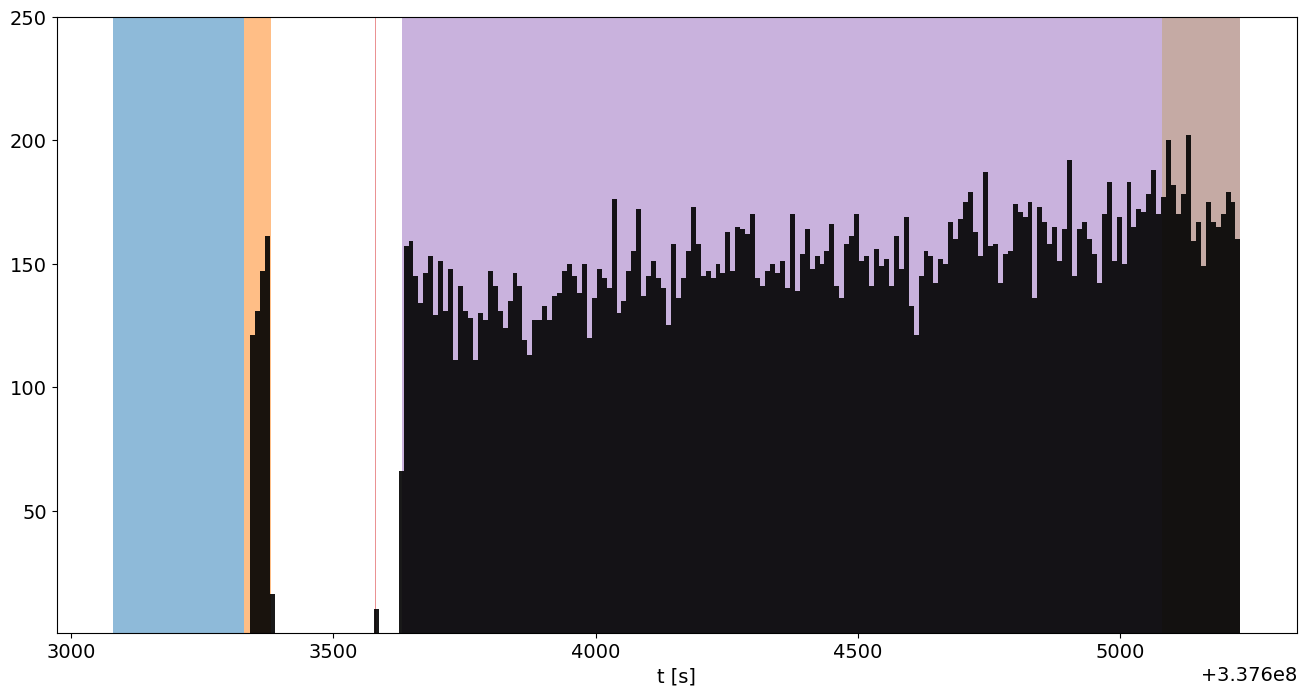

In [29]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
for i_int in range(len(good_time_ints)):
    ax.fill_between(x = good_time_ints[i_int], y1 = 2*[10**5],alpha=0.5)
ax.hist(df_events['t'],bins=200,color='black',alpha=0.9,log='False');
ax.set_xlabel('t [s]'); 
ax.set_yscale('linear')
ax.set_ylim(0.5,250);

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.hist2d(df_events['t'],df_events['E'],bins=[100,200],norm=mp.colors.LogNorm());
ax.set_xlabel('t [s]'); ax.set_ylabel('E [keV]');
ax.set_ylim(0,100)

# Scratch

In [10]:
df_events = load_events(list_file_events)
df_exp = load_exp(bins_t,good_time_ints)
df_box = load_box(file_box_centers)
df_arf_m = load_arf_m(list_file_arf,bins_E,df_box,m,sigma_E,n_sigma_E)

In [12]:
df_events

,detector,t,E,ra,dec
0,A,3.376033e+08,2.04,170.894753,3.983816
1,A,3.376033e+08,1.88,170.902966,3.914852
2,A,3.376033e+08,2.20,170.859849,3.921680
3,A,3.376033e+08,2.48,170.910495,3.991327
4,A,3.376033e+08,2.88,170.956349,3.940799
...,...,...,...,...,...
13688,B,3.376052e+08,2.64,170.911179,3.826770
13689,B,3.376052e+08,2.72,170.913917,3.998155
13690,B,3.376052e+08,2.24,170.905704,3.992010
13691,B,3.376052e+08,1.80,170.878328,3.922363


In [14]:
df_data

,detector,idx_t,idx_E,i1,i2,t,E,ra,dec,exp,arf,Omega,counts
0,A,0,173,-6,-6,337603330.0,8.52,170.889,3.75981,39.504368,113.094009,1.0,0
1,A,0,173,-6,-5,337603330.0,8.52,170.881,3.77425,39.504368,82.943665,1.0,0
2,A,0,173,-6,-4,337603330.0,8.52,170.872,3.78868,39.504368,138.742828,1.0,0
3,A,0,173,-6,-3,337603330.0,8.52,170.864,3.80311,39.504368,138.469910,1.0,0
4,A,0,173,-6,-2,337603330.0,8.52,170.856,3.81755,39.504368,244.743439,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84495,B,9,197,6,2,337605040.0,9.48,171.009,3.97187,147.406154,135.821762,1.0,0
84496,B,9,197,6,3,337605040.0,9.48,171.001,3.98630,147.406154,110.902191,1.0,0
84497,B,9,197,6,4,337605040.0,9.48,170.992,4.00073,147.406154,79.826294,1.0,0
84498,B,9,197,6,5,337605040.0,9.48,170.984,4.01517,147.406154,77.881058,1.0,0


In [16]:
df_box

,detector,i1,i2,ra,dec,delta_x,delta_y,rotation
0,A,0,0,170.926,3.89641,1.000',1.000',330
1,A,1,0,170.940,3.90475,1.000',1.000',330
2,A,-1,0,170.911,3.88808,1.000',1.000',330
3,A,2,0,170.955,3.91308,1.000',1.000',330
4,A,-2,0,170.897,3.87975,1.000',1.000',330
...,...,...,...,...,...,...,...,...
333,B,6,5,170.984,4.01517,1.000',1.000',330
334,B,-6,-6,170.902,3.75640,1.000',1.000',330
335,B,6,-6,171.076,3.85640,1.000',1.000',330
336,B,-6,6,170.802,3.92960,1.000',1.000',330


In [11]:
df_events_bin = binned_events(df_events,bins_t,bins_E,df_box,m,sigma_E)

In [12]:
df_events_bin

,detector,idx_t,idx_E,i1,i2,0
0,A,0,182,-6,3,1
1,B,0,172,4,2,1
2,B,0,182,1,-5,1
3,B,0,184,-1,0,1
4,A,1,191,4,5,1
5,A,2,194,-6,3,1
6,A,2,195,2,4,1
7,B,2,178,-5,-3,1
8,A,3,180,4,1,1
9,A,3,185,4,-4,1


In [21]:
df_indexed = indexed_events(df_events,bins_t,bins_E,df_box,m,sigma_E)
    
df_bin = df_indexed.groupby(df_indexed.columns.tolist(),as_index=False).size().reset_index()
df_bin = df_bin.rename(columns={"size": "counts"})

df_bin = df_bin.sort_values(by=['idx_t','detector','idx_E','i1','i2'])#,ignore_index=True)
df_bin = df_bin.reset_index()
df_bin = df_bin.drop(columns=['index'])

In [22]:
df_bin

,detector,idx_t,idx_E,i1,i2,0
0,A,0,182,-6,3,1
1,B,0,172,4,2,1
2,B,0,182,1,-5,1
3,B,0,184,-1,0,1
4,A,1,191,4,5,1
5,A,2,194,-6,3,1
6,A,2,195,2,4,1
7,B,2,178,-5,-3,1
8,A,3,180,4,1,1
9,A,3,185,4,-4,1


In [14]:
df_arf = load_arf(list_file_arf,bins_E,df_box)
df_arf_m = df_arf[np.abs(bins_E[df_arf['idx_E']]-m/2) < n_sigma_E*sigma_E]
df_arf_m = df_arf_m.sort_values(by=['detector','idx_E','i1','i2'])#,ignore_index=True)
df_arf_m = df_arf_m.reset_index()

In [15]:
df_arf_m

,index,detector,idx_E,i1,i2,ra,dec,arf
0,286893,A,173,-6,-6,170.889,3.75981,113.094009
1,282797,A,173,-6,-5,170.881,3.77425,82.943665
2,278701,A,173,-6,-4,170.872,3.78868,138.742828
3,274605,A,173,-6,-3,170.864,3.80311,138.469910
4,270509,A,173,-6,-2,170.856,3.81755,244.743439
...,...,...,...,...,...,...,...,...
8445,1364165,B,197,6,2,171.009,3.97187,135.821762
8446,1368261,B,197,6,3,171.001,3.98630,110.902191
8447,1372357,B,197,6,4,170.992,4.00073,79.826294
8448,1376453,B,197,6,5,170.984,4.01517,77.881058


In [13]:
df_data = pd.DataFrame()
for idx_t,t in enumerate(bins_t[:-1]):
    exp = df_exp[df_exp['idx_t']==idx_t]['exp'].to_numpy()[0]
    tmp = df_arf_m.copy(deep=True)
    tmp.insert(1,'idx_t',idx_t)
    tmp.insert(7,'exp',exp)
    df_data = df_data.append(tmp,ignore_index=True)
df_data.insert(5,'t',bins_t[df_data['idx_t']])
df_data.insert(6,'E',bins_E[df_data['idx_E']])
df_data.insert(11,'Omega',1.0)
df_data.insert(12,'counts',0)

In [15]:
## correct for livetime
df_data.loc[df_data['detector']=='A','exp'] = livetime[0] * df_data.loc[df_data['detector']=='A','exp']
df_data.loc[df_data['detector']=='B','exp'] = livetime[1] * df_data.loc[df_data['detector']=='B','exp']

In [16]:
df_data

,detector,idx_t,idx_E,i1,i2,t,E,ra,dec,exp,arf,Omega,counts
0,A,0,173,-6,-6,337603330.0,8.52,170.889,3.75981,39.504368,113.094009,1.0,0
1,A,0,173,-6,-5,337603330.0,8.52,170.881,3.77425,39.504368,82.943665,1.0,0
2,A,0,173,-6,-4,337603330.0,8.52,170.872,3.78868,39.504368,138.742828,1.0,0
3,A,0,173,-6,-3,337603330.0,8.52,170.864,3.80311,39.504368,138.469910,1.0,0
4,A,0,173,-6,-2,337603330.0,8.52,170.856,3.81755,39.504368,244.743439,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84495,B,9,197,6,2,337605040.0,9.48,171.009,3.97187,147.406154,135.821762,1.0,0
84496,B,9,197,6,3,337605040.0,9.48,171.001,3.98630,147.406154,110.902191,1.0,0
84497,B,9,197,6,4,337605040.0,9.48,170.992,4.00073,147.406154,79.826294,1.0,0
84498,B,9,197,6,5,337605040.0,9.48,170.984,4.01517,147.406154,77.881058,1.0,0


In [17]:
## adding in event data
df_merge = df_data.append(df_events_bin) # merge source data and event data frames
df_merge

,E,Omega,arf,counts,dec,detector,exp,i1,i2,idx_E,idx_t,ra,t,0
0,8.52,1.0,113.094009,0.0,3.75981,A,39.504368,-6,-6,173,0,170.889,337603330.0,NaN
1,8.52,1.0,82.943665,0.0,3.77425,A,39.504368,-6,-5,173,0,170.881,337603330.0,NaN
2,8.52,1.0,138.742828,0.0,3.78868,A,39.504368,-6,-4,173,0,170.872,337603330.0,NaN
3,8.52,1.0,138.469910,0.0,3.80311,A,39.504368,-6,-3,173,0,170.864,337603330.0,NaN
4,8.52,1.0,244.743439,0.0,3.81755,A,39.504368,-6,-2,173,0,170.856,337603330.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,NaN,NaN,NaN,NaN,NaN,B,NaN,3,-4,192,8,NaN,NaN,1.0
38,NaN,NaN,NaN,NaN,NaN,A,NaN,-6,0,172,9,NaN,NaN,1.0
39,NaN,NaN,NaN,NaN,NaN,A,NaN,6,-2,183,9,NaN,NaN,1.0
40,NaN,NaN,NaN,NaN,NaN,A,NaN,-2,-6,185,9,NaN,NaN,1.0


In [18]:
idx_first = df_merge.duplicated(subset=['detector','idx_t','idx_E','i1','i2'],keep='first') # row indices of events
idx_last = df_merge.duplicated(subset=['detector','idx_t','idx_E','i1','i2'],keep='last') # row indices of source

In [19]:
print(idx_first,idx_last)

0     False
1     False
2     False
3     False
4     False
      ...  
37     True
38    False
39     True
40     True
41     True
Length: 84542, dtype: bool 0     False
1     False
2     False
3     False
4     False
      ...  
37    False
38    False
39    False
40    False
41    False
Length: 84542, dtype: bool


In [30]:
#df_data.loc[idx_last[0:len(df_data)],'counts'] = np.asarray(df_merge.iloc[np.where(idx_first)[0]]['counts'].fillna(0),dtype=int) # add events
df_data.loc[idx_last[0:len(df_data)],'counts'] = np.asarray(df_merge.iloc[np.where(idx_first)[0]][0].fillna(0),dtype=int)

In [32]:
df_data

,detector,idx_t,idx_E,i1,i2,t,E,ra,dec,exp,arf,Omega,counts
0,A,0,173,-6,-6,337603330.0,8.52,170.889,3.75981,39.504368,113.094009,1.0,0
1,A,0,173,-6,-5,337603330.0,8.52,170.881,3.77425,39.504368,82.943665,1.0,0
2,A,0,173,-6,-4,337603330.0,8.52,170.872,3.78868,39.504368,138.742828,1.0,0
3,A,0,173,-6,-3,337603330.0,8.52,170.864,3.80311,39.504368,138.469910,1.0,0
4,A,0,173,-6,-2,337603330.0,8.52,170.856,3.81755,39.504368,244.743439,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84495,B,9,197,6,2,337605040.0,9.48,171.009,3.97187,147.406154,135.821762,1.0,0
84496,B,9,197,6,3,337605040.0,9.48,171.001,3.98630,147.406154,110.902191,1.0,0
84497,B,9,197,6,4,337605040.0,9.48,170.992,4.00073,147.406154,79.826294,1.0,0
84498,B,9,197,6,5,337605040.0,9.48,170.984,4.01517,147.406154,77.881058,1.0,0


In [33]:
sum(df_data['counts'])

38

In [42]:
df_samples = pd.DataFrame(data=samples,columns=['B0','T0','S0','alpha0','delta0'])

In [43]:
df_samples

,B0,T0,S0,alpha0,delta0
0,0.001505,0.637394,-0.000117,2.978805,0.071633
1,0.001455,0.563946,-0.000064,2.978944,0.069735
2,0.001210,0.560661,-0.000063,2.977829,0.070749
3,0.001137,0.488378,0.000058,2.978774,0.070606
4,0.001362,0.557031,-0.000036,2.979340,0.070234
...,...,...,...,...,...
31995,0.001865,1.082954,-0.000148,2.978178,0.070312
31996,0.001766,2.220528,-0.000154,2.978048,0.070615
31997,0.001561,1.395248,-0.000033,2.978486,0.069831
31998,0.001822,1.158940,-0.000060,2.978143,0.070527


In [44]:
with open('test.csv', 'a') as f:
    df_samples.to_csv(f, index=False, mode='a',header=True)

In [70]:
def likelihood_MCMC_5_test(model_inputs,m,t,E,ra,dec,eps,counts):
    B0 = model_inputs[0]
    T0 = model_inputs[1]
    S0 = model_inputs[2]
    #alpha0=170.66855149
    #delta0=4.02092024
    ra_sun_0 = model_inputs[3]
    dec_sun_0 = model_inputs[4]

    flux_bkgd = B0*np.exp(-(E-m/2)/T0)
    T_flux = T_flux_template(t,ra,dec,ra_sun_0,dec_sun_0,delta_ra_sun,delta_dec_sun,t_min,duration)
    flux_signal = S0 * T_flux * np.exp(-(E-m/2)**2/(2*sigma_E**2)) / np.sqrt(2 * np.pi * sigma_E**2)

    min_T0 = np.max(-(E-m/2)) / 700
    #print('min_T0 = ', min_T0)

    mu = (flux_bkgd + flux_signal) * eps

    if mu.any() <= 0:
        print('mu has a negative value')
    if np.isnan(T_flux).any() == True:
        print('nan in T_flux_template')

    LLp = LL_prior(B0,T0,S0,ra_sun_0,dec_sun_0)

    if np.min(mu) <= 0:
        print('step skipped: neg mu')
        #return -np.inf
        return(-np.abs(S0)*10**100)
    elif T0 < min_T0:
        print('step skipped: T0 = ',T0)
        return -np.inf
    else:
        try:
            #LL = counts*np.log(mu)-mu-np.log(factorial_vec(counts))
            LL = counts*np.log(mu)-mu # not including factorial, as it does not depend on model params
            loss = 2 * (np.sum(LL) - LLp)
            return loss
        except ValueError:
            print('value error')
            print('min mu = ', min(mu))
            print('LLp = ',LLp)
            return -np.inf


In [84]:
S0_list = np.linspace(-1,0,1000)
ll_list = [likelihood_MCMC_5_test([1.746,1.221,i,179.649,4.029],m,t,E,ra,dec,eps,counts) for i in S0_list]

Text(0, 0.5, 'LL')

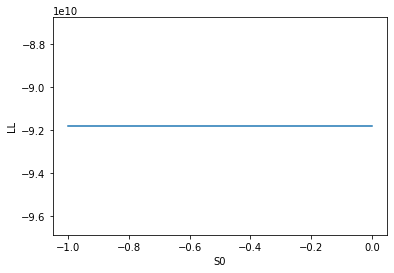

In [85]:
plt.plot(S0_list,ll_list)
plt.xlabel('S0')
plt.ylabel('LL')

In [72]:
def likelihood_MCMC_5(model_inputs,m,t,E,ra,dec,eps,counts):
    B0 = model_inputs[0]
    T0 = model_inputs[1]
    S0 = model_inputs[2]
    #alpha0=170.66855149
    #delta0=4.02092024
    ra_sun_0 = model_inputs[3]
    dec_sun_0 = model_inputs[4]
    flux_bkgd = B0*np.exp(-(E-m/2)/T0)
    flux_signal = S0 * T_flux_template(t,ra,dec,ra_sun_0,dec_sun_0,delta_ra_sun,delta_dec_sun,t_min,duration) * np.exp(-(E-m/2)**2/(2*sigma_E**2)) / np.sqrt(2 * np.pi * sigma_E**2)
    mu = (flux_bkgd + flux_signal) * eps
    
    LLp = LL_prior(B0,T0,S0,ra_sun_0,dec_sun_0)
    
    if np.min(mu) < 0 or T0 <0: 
        print('skip')
        return -np.inf
    else:
        try:
            #LL = counts*np.log(mu)-mu-np.log(factorial_vec(counts)) 
            LL = counts*np.log(mu)-mu # not including factorial, as it does not depend on model params
            loss = 2 * (np.sum(LL) - LLp)
            return loss
        except ValueError:
            print('value error')
            print('min mu = ', min(mu))
            print('LLp = ',LLp)
            return -np.inf

In [73]:
likelihood_MCMC_5([1.746,1.221,-0.9,179.649,4.029],m,t,E,ra,dec,eps,counts)

-91810757670.505

In [88]:
T_flux_template?

Signature:
T_flux_template(
    t,
    ra,
    dec,
    ra_sun_0,
    dec_sun_0,
    delta_ra_sun,
    delta_dec_sun,
    t_min,
    duration,
)
Docstring: Calculate spatial template function for signal.
File:      c:\users\shalm\dropbox\luminousbasin\code\shalma code\new_versions\model_functions.py
Type:      function


In [95]:
alpha0_list = np.linspace(50,150,100)
delta0_list = np.linspace(-10,50,100)
for a in alpha0_list:
    for d in delta0_list:
        t = T_flux_template(t,a,d,ra_sun_0,dec_sun_0,delta_ra_sun,delta_dec_sun,t_min,duration)
        if t.any()<= 0:
            print('Neg T flux')
            print('t_flux = ',t)
            print('ra = ',a)
            print('dec = ',d)